Modelos Preditivos:
-

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier  # CORRIGIDO
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [4]:

# Caminho relativo correto a partir da pasta 'notebooks'
df = pd.read_pickle('../data/df_unique.pkl')

# Cria uma cópia independente
df_copy = df.copy()

# Salva a cópia em um novo arquivo .pkl
df_copy.to_pickle('../data/df_unique_copy.pkl')

# Alterar configuração para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Exibindo as primeiras linhas do DataFrame
df_copy.head()


,age,amt_active_loan,channel,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,ids,income,occupation_type,score_checks,score_date,start_hour,default,credit_card_initial_line,payment,date,credit_line,spends
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,198.40,2016-09-30,2180.0,198.40
1,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,149.94,2016-10-31,2368.0,145.49
2,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,10.02,2016-11-30,3103.0,10.02
3,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,38.48,2016-12-31,2430.0,278.05
4,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,2888.77,2017-01-31,2650.0,2888.77


Variável target:
-

In [5]:
print("Contagem de valores únicos na coluna 'default':")
print(df_copy['default'].value_counts(dropna=False))


Contagem de valores únicos na coluna 'default':
default
False    290926
True      59341
NaN       26827
Name: count, dtype: int64


In [6]:
df_copy['default'] = df_copy['default'].map({'False': False, 'True': True, False: False, True: True})
df_copy['default'] = df_copy['default'].map({False: 0, True: 1})
df_copy = df_copy[df_copy['default'].notna()]

Divisão do conjunto de dados:
-

In [7]:
# Separação em features e target:
X = df_copy.drop(columns=['default'])
y = df_copy['default']


# Divisão em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # importante para problemas desbalanceados
)

Modelo Baseline:
-

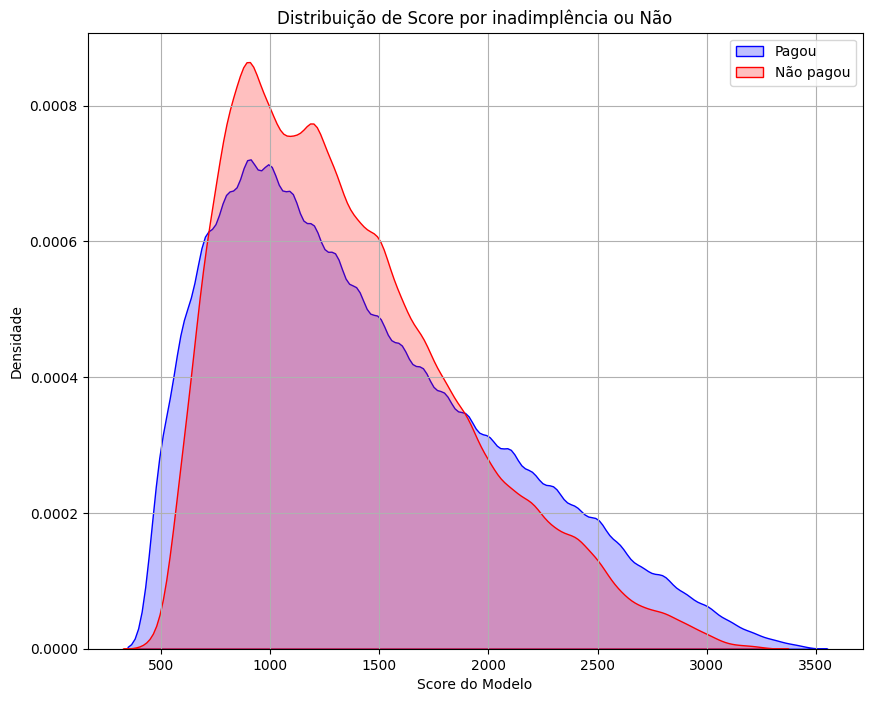

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.kdeplot(df_copy[df_copy['default'] == 0]['credit_card_initial_line'], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(df_copy[df_copy['default'] == 1]['credit_card_initial_line'], ax=ax, color="r", fill=True, label='Não pagou')

plt.title("Distribuição de Score por inadimplência ou Não")
plt.xlabel("Score do Modelo")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
fpr, tpr, thresholds = roc_curve(df_copy['default'], df_copy['credit_card_initial_line'])
auc = auc(fpr, tpr)
print("ROC AUC: ", auc)

ROC AUC:  0.48900352453027973


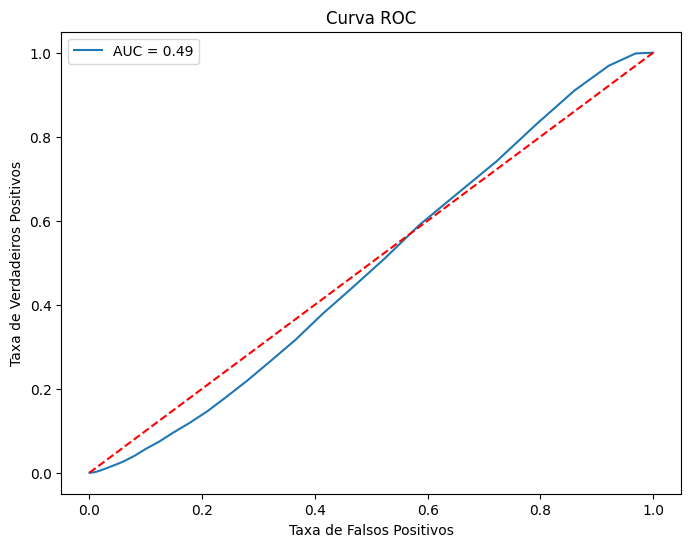

In [10]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [11]:
# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline para numéricos: imputar média + escalar
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para categóricos: imputar moda + one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar preprocessadores
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Pipeline final
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Treinar
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'ext_score_4',
                                                   'income', 'score_checks',
                                                   'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment', 'credit_line',
                                                   'spends']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['channel', 'ext_score_2',
                                                   'ext_score_3',
                                                   'flag_document_A', 'gender',
                                                   'ids', 'occupation_type',
                                                   'score_date', 'date'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58186
         1.0       1.00      0.93      0.96     11868

    accuracy                           0.99     70054
   macro avg       0.99      0.97      0.98     70054
weighted avg       0.99      0.99      0.99     70054

ROC AUC: 0.9980960086264276


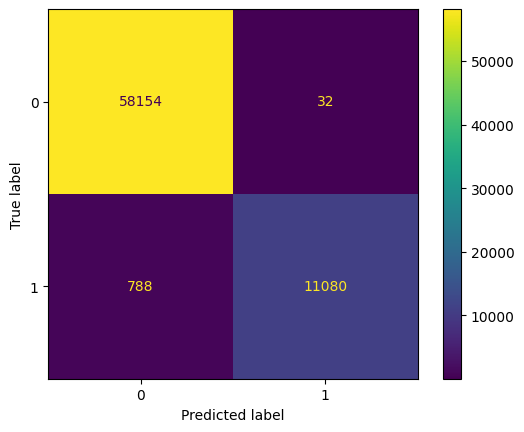

In [12]:
# Previsões no teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]   # Probabilidade de ser '1' (inadimplente)

# Métricas
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusão
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [ ]:
# Matriz de confusão
TN = 58154
FP = 32
FN = 788
TP = 11080

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)

print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")


Taxa de inadimplência na base = 16.939999999999998%
Taxa de aprovação pelo modelo = 15.76%


Log Loss: 0.0928


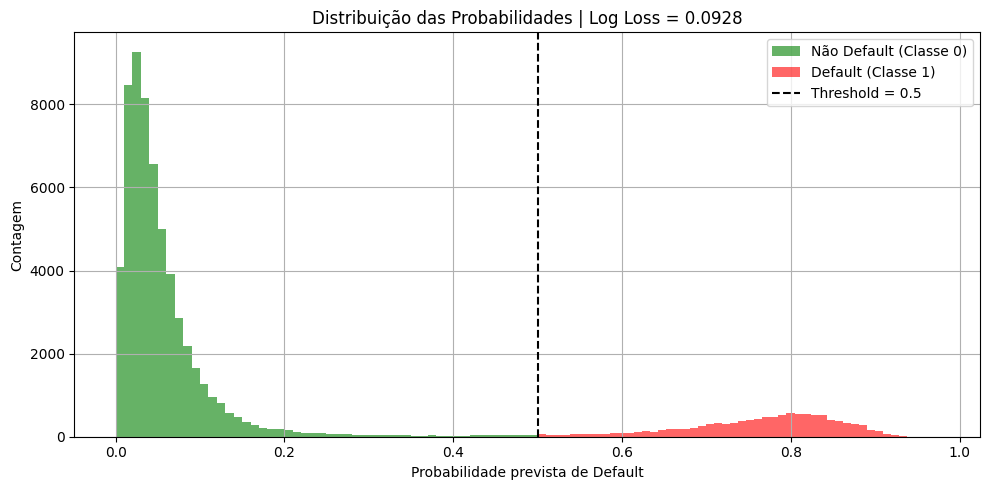

In [14]:
#  Calcular e plotar o Log Loss
y_test = y_pred  # ou df_copy_encoded["default"]
y_proba = model.predict_proba(X_test)[:, 1]

# 1. Calcular o Log Loss
logloss_value = log_loss(y_test, y_proba)
print(f"Log Loss: {logloss_value:.4f}")

# 2. Plotar histograma das probabilidades para visualização
plt.figure(figsize=(10, 5))
plt.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label='Não Default (Classe 0)', color='green')
plt.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label='Default (Classe 1)', color='red')
plt.axvline(0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.title(f'Distribuição das Probabilidades | Log Loss = {logloss_value:.4f}')
plt.xlabel('Probabilidade prevista de Default')
plt.ylabel('Contagem')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Feature Engineering:
-

Engenharia de Atributos (ou Feature Engineering) é a etapa do processo de análise de dados que envolve a criação, transformação e seleção de variáveis que são mais relevantes para o problema em questão. Essa fase é essencial no desenvolvimento de modelos de Machine Learning, pois a forma como essas variáveis são construídas pode impactar diretamente o desempenho do modelo, influenciando sua precisão e sua capacidade de fazer boas previsões em novos dados.

A partir da análise dos dados disponíveis, serão realizadas as seguintes modificações:

#### 1. Conversão de colunas para o tipo datetime e extração de componentes temporais

- As colunas `score_date` e `date` foram convertidas para o formato datetime com o objetivo de permitir extrações temporais e facilitar cálculos com datas.
- Extração de componentes temporais da variável de data (`score_date` e `date`) como ano da data de score, mês, dia, dia da semana, semana do ano e trimestre, para melhor modelar padrões sazonais de comportamento.

#### 2. Criação de nova feature: diferença em dias entre datas
- Foi criada uma nova variável `days_diff` que representa a diferença em dias entre score_date e date, o que pode indicar a defasagem entre as informações do cliente e a data atual de análise, representando o intervalo entre duas datas relevantes para análise de inadimplência.

#### 3. Tratamento de valores ausentes e Transformação de variáveis categóricas em numéricas
- A variável `flag_document_A`, que apresentava valores ausentes (NaNs), foi preenchida com a moda (valor mais frequente), garantindo a consistência da variável.
- Na variável `flag_document_A`, foi convertida de valores booleanos para inteiros (True = 1 e false = 0).
- na variável `gender`,foi mapeada de texto para valores binários (m = 1 e f = 0).

#### 4. Codificação One-Hot Encoding
- Variáveis categóricas codificadas com hashes (como `ext_score_2` e `ext_score_3`) foram transformadas em variáveis binárias usando a técnica one-hot encoding, criando uma coluna para cada categoria distinta.
- Essa transformação resulta em várias novas colunas, permitindo que o modelo trate essas categorias de forma apropriada.


#### 5. Target Encoding com K-Fold Cross-Validation
- Para transformar a variável categórica `occupation_type`, foi aplicada a técnica de **Target Encoding** com validação cruzada. Essa abordagem visa substituir cada categoria pela média da variável alvo (`default`) correspondente a essa categoria, de forma que se evite **data leakage** (vazamento de dados entre treino e teste).
- Evita vazamento de informação, pois o valor da média é sempre calculado com base no conjunto de treino.
- Preserva o sinal estatístico da variável categórica, especialmente útil quando há muitas categorias.
- Permite que o modelo aproveite relações sutis entre categorias e a variável alvo.

#### 6. Remoção de Colunas Irrelevantes
- Após a extração das informações relevantes a partir das colunas de data, as colunas (`channel`, `ids`, `score_date`, `date`) foram descartadas, uma vez que seu conteúdo bruto já não é mais necessário para o modelo.




#### Essas etapas de engenharia de atributos permitirão:

- Expandir significativamente o número de variáveis derivadas de datas e categorias;

- Tratar valores ausentes de forma robusta;

- Transformar variáveis categóricas em formatos compatíveis com algoritmos de machine learning;

- Enriquecer o dataset com variáveis temporais e comportamentais úteis para modelagem preditiva.

Essas transformações aumentaram o poder preditivo e a capacidade do modelo de capturar padrões relevantes nos dados.


In [15]:
# Garantindo que as colunas estão no formato datetime
df_copy['score_date'] = pd.to_datetime(df_copy['score_date'])
df_copy['date'] = pd.to_datetime(df_copy['date'])

# Extraindo features de score_date
df_copy['score_year'] = df_copy['score_date'].dt.year
df_copy['score_month'] = df_copy['score_date'].dt.month
df_copy['score_day'] = df_copy['score_date'].dt.day
df_copy['score_dayofweek'] = df_copy['score_date'].dt.dayofweek
df_copy['score_weekofyear'] = df_copy['score_date'].dt.isocalendar().week
df_copy['score_quarter'] = df_copy['score_date'].dt.quarter

# Extraindo features de date
df_copy['date_year'] = df_copy['date'].dt.year
df_copy['date_month'] = df_copy['date'].dt.month
df_copy['date_day'] = df_copy['date'].dt.day
df_copy['date_dayofweek'] = df_copy['date'].dt.dayofweek
df_copy['date_weekofyear'] = df_copy['date'].dt.isocalendar().week
df_copy['date_quarter'] = df_copy['date'].dt.quarter

# (Opcional) Criando feature de diferença em dias entre as duas datas
df_copy['days_diff'] = (df_copy['score_date'] - df_copy['date']).dt.days


In [16]:
# Drop  columns
df_copy.drop(['channel', 'ids', 'score_date', 'date'], axis=1, inplace=True)

# Preencher valores nulos de flag_document_A com a moda
df_copy['flag_document_A'] = df_copy['flag_document_A'].fillna(df_copy['flag_document_A'].mode()[0])
df_copy['flag_document_A'] = df_copy['flag_document_A'].astype(bool).astype(int)


# Mapear True/False para 1/0
df_copy['flag_document_A'] = df_copy['flag_document_A'].astype(bool).astype(int)

# Mapear os valores da variável gender: 'm' → 1 e 'f' → 0
df_copy['gender'] = df_copy['gender'].map({'m': 1, 'f': 0})

df_copy.head(2)

C:\Users\User\AppData\Local\Temp\ipykernel_9388\1561918248.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['flag_document_A'] = df_copy['flag_document_A'].fillna(df_copy['flag_document_A'].mode()[0])


,age,amt_active_loan,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,income,occupation_type,score_checks,start_hour,default,credit_card_initial_line,payment,credit_line,spends,score_year,score_month,score_day,score_dayofweek,score_weekofyear,score_quarter,date_year,date_month,date_day,date_dayofweek,date_weekofyear,date_quarter,days_diff
0,37,4560.0,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,198.40,2180.0,198.40,2017,1,15,6,2,1,2016,9,30,4,39,3,107
1,37,4560.0,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,149.94,2368.0,145.49,2017,1,15,6,2,1,2016,10,31,0,44,4,76


In [17]:
# Remover espaços e verificar valores únicos
df_copy['ext_score_2_clean'] = df_copy['ext_score_2'].astype(str).str.strip()

df_copy['ext_score_3_clean'] = df_copy['ext_score_3'].astype(str).str.strip()

# Criar categorias fixas com pd.Categorical
ext_score_2_categories = df_copy['ext_score_2_clean'].unique()
df_copy['ext_score_2_cat'] = pd.Categorical(df_copy['ext_score_2_clean'], categories=ext_score_2_categories)

ext_score_3_categories = df_copy['ext_score_3_clean'].unique()
df_copy['ext_score_3_cat'] = pd.Categorical(df_copy['ext_score_3_clean'], categories=ext_score_3_categories)

In [18]:
ext_score_2_encoded = pd.get_dummies(df_copy['ext_score_2_cat'], prefix='ext_score_2').astype(int)
print(ext_score_2_encoded.head())


   ext_score_2_DGCQep2AE5QRkNCshIAlFQ==  ext_score_2_e4NYDor1NOw6XKGE60AWFw==  \
0                                     1                                     0   
1                                     1                                     0   
2                                     1                                     0   
3                                     1                                     0   
4                                     1                                     0   

   ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==  ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   ext_score_2_8k8UDR4Yx0q

In [19]:
ext_score_3_encoded = pd.get_dummies(df_copy['ext_score_3_cat'], prefix='ext_score_3').astype(int)
print(ext_score_3_encoded.head())

   ext_score_3_LCak332j+TYFqHC3NDwiqg==  ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==  \
0                                     1                                     0   
1                                     1                                     0   
2                                     1                                     0   
3                                     1                                     0   
4                                     1                                     0   

   ext_score_3_NLvAOzzmJba/0zolQnWF5Q==  ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   ext_score_3_w1miZqhB5+R

In [20]:
df_copy_encoded = pd.concat([
    df_copy.drop(columns=['ext_score_2', 'ext_score_2_clean', 'ext_score_2_cat']),
    ext_score_2_encoded
], axis=1)

df_copy_encoded = pd.concat([
    df_copy_encoded.drop(columns=['ext_score_3', 'ext_score_3_clean', 'ext_score_3_cat']),
    ext_score_3_encoded
], axis=1)

pd.set_option('display.max_columns', None)

ext_cols = [col for col in df_copy_encoded.columns if 'ext_score_2' in col or 'ext_score_3' in col]
other_cols = [col for col in df_copy_encoded.columns if col not in ext_cols]

df_copy_encoded = df_copy_encoded[other_cols + ext_cols]
df_copy_encoded.head()


,age,amt_active_loan,ext_score_1,ext_score_4,flag_document_A,gender,income,occupation_type,score_checks,start_hour,default,credit_card_initial_line,payment,credit_line,spends,score_year,score_month,score_day,score_dayofweek,score_weekofyear,score_quarter,date_year,date_month,date_day,date_dayofweek,date_weekofyear,date_quarter,days_diff,ext_score_2_DGCQep2AE5QRkNCshIAlFQ==,ext_score_2_e4NYDor1NOw6XKGE60AWFw==,ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==,ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==,ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==,ext_score_2_4DLlLW62jReXaqbPaHp1vQ==,ext_score_2_smzX0nxh5QlePvtVf6EAeg==,ext_score_3_LCak332j+TYFqHC3NDwiqg==,ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==,ext_score_3_NLvAOzzmJba/0zolQnWF5Q==,ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==,ext_score_3_w1miZqhB5+RSamEQJa0rqg==,ext_score_3_dCm9hFKfdRm7ej3jW+gyxw==,ext_score_3_O4i7FxcROACMVTCgI0WXuA==,ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==,ext_score_3_pAzpxkhjPsjWldgSX21+zg==,ext_score_3_7h+tk4z7O9brtBSe1rNjxA==,ext_score_3_mX2VRRG38RPiHX+MfjefRw==,ext_score_3_tQUTfUyeuGkhRotd+6WjVg==,ext_score_3_OlDYtdljgSSYM/M1L2CRaQ==,ext_score_3_RO7MTL+j4PH2gNzbhNTq/A==,ext_score_3_emS9xH8CLoRNie2uSmaDAQ==,ext_score_3_vJyc9xom9v7hwFMPTIpmKw==,ext_score_3_wjdj2vxjWoDsEIk0l09ynw==,ext_score_3_ky19q4V1ZqgL3jnHX0wKDw==,ext_score_3_d/7Hedyz7ovK9Pn1CYN4+A==,ext_score_3_YLGMUI9hObSh6wD/xfanGg==,ext_score_3_osCzpM4hJrxugqWWuZmMWw==,ext_score_3_wkeCdGeu5sEv4/fjwR0aDg==,ext_score_3_/tdlnWjXoZ3OjdtBXzdOJQ==,ext_score_3_dWJRASUFMejk3AHZ1p1Gkg==,ext_score_3_tHpS8e9F8d9zg3iOQM9tsA==,ext_score_3_6J1ZMTzN5GKHXnhM4J1JbA==,ext_score_3_55UK234RR1d7HIWJjmq9tw==,ext_score_3_IOVu8au3ISbo6+zmfnYwMg==,ext_score_3_SaamrHMo23l/3TwXOWgVzw==,ext_score_3_cdpgyOyZS04uXerMNu7uCw==,ext_score_3_A+QuW1n/ABeiVVe/9CRZ9Q==,ext_score_3_7h8PTkrlTWUPP3yuyP4rUg==,ext_score_3_+CxEO4w7jv3QPI/BQbyqAA==,ext_score_3_5/uMrqKj3OL/Xk5OrGx9fg==,ext_score_3_bopP0NxW3+r8tn9xIHTaOw==
0,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,198.40,2180.0,198.40,2017,1,15,6,2,1,2016,9,30,4,39,3,107,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,149.94,2368.0,145.49,2017,1,15,6,2,1,2016,10,31,0,44,4,76,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,10.02,3103.0,10.02,2017,1,15,6,2,1,2016,11,30,2,48,4,46,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,38.48,2430.0,278.05,2017,1,15,6,2,1,2016,12,31,5,52,4,15,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,2888.77,2650.0,2888.77,2017,1,15,6,2,1,2017,1,31,1,5,1,-16,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# Parâmetros
n_splits = 5
target_col = 'default'
cat_col = 'occupation_type'
encoded_col = cat_col + '_te'

# Inicializa a nova coluna
df_copy_encoded[encoded_col] = np.nan

# KFold 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(df_copy_encoded):
    train_fold = df_copy_encoded.iloc[train_idx]
    val_fold = df_copy_encoded.iloc[val_idx]
    
    # Cálculo do target mean por categoria
    means = train_fold.groupby(cat_col)[target_col].mean()
    
    # Mapeia no fold de validação
    df_copy_encoded.loc[df_copy_encoded.index[val_idx], encoded_col] = val_fold[cat_col].map(means)

# Após o loop, pode preencher categorias ausentes com o global mean
global_mean = df_copy_encoded[target_col].mean()
df_copy_encoded[encoded_col].fillna(global_mean, inplace=True)

df_copy_encoded.drop(columns=[cat_col], inplace=True)

df_copy_encoded.head()

C:\Users\User\AppData\Local\Temp\ipykernel_9388\1243101446.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy_encoded[encoded_col].fillna(global_mean, inplace=True)


,age,amt_active_loan,ext_score_1,ext_score_4,flag_document_A,gender,income,score_checks,start_hour,default,credit_card_initial_line,payment,credit_line,spends,score_year,score_month,score_day,score_dayofweek,score_weekofyear,score_quarter,date_year,date_month,date_day,date_dayofweek,date_weekofyear,date_quarter,days_diff,ext_score_2_DGCQep2AE5QRkNCshIAlFQ==,ext_score_2_e4NYDor1NOw6XKGE60AWFw==,ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==,ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==,ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==,ext_score_2_4DLlLW62jReXaqbPaHp1vQ==,ext_score_2_smzX0nxh5QlePvtVf6EAeg==,ext_score_3_LCak332j+TYFqHC3NDwiqg==,ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==,ext_score_3_NLvAOzzmJba/0zolQnWF5Q==,ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==,ext_score_3_w1miZqhB5+RSamEQJa0rqg==,ext_score_3_dCm9hFKfdRm7ej3jW+gyxw==,ext_score_3_O4i7FxcROACMVTCgI0WXuA==,ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==,ext_score_3_pAzpxkhjPsjWldgSX21+zg==,ext_score_3_7h+tk4z7O9brtBSe1rNjxA==,ext_score_3_mX2VRRG38RPiHX+MfjefRw==,ext_score_3_tQUTfUyeuGkhRotd+6WjVg==,ext_score_3_OlDYtdljgSSYM/M1L2CRaQ==,ext_score_3_RO7MTL+j4PH2gNzbhNTq/A==,ext_score_3_emS9xH8CLoRNie2uSmaDAQ==,ext_score_3_vJyc9xom9v7hwFMPTIpmKw==,ext_score_3_wjdj2vxjWoDsEIk0l09ynw==,ext_score_3_ky19q4V1ZqgL3jnHX0wKDw==,ext_score_3_d/7Hedyz7ovK9Pn1CYN4+A==,ext_score_3_YLGMUI9hObSh6wD/xfanGg==,ext_score_3_osCzpM4hJrxugqWWuZmMWw==,ext_score_3_wkeCdGeu5sEv4/fjwR0aDg==,ext_score_3_/tdlnWjXoZ3OjdtBXzdOJQ==,ext_score_3_dWJRASUFMejk3AHZ1p1Gkg==,ext_score_3_tHpS8e9F8d9zg3iOQM9tsA==,ext_score_3_6J1ZMTzN5GKHXnhM4J1JbA==,ext_score_3_55UK234RR1d7HIWJjmq9tw==,ext_score_3_IOVu8au3ISbo6+zmfnYwMg==,ext_score_3_SaamrHMo23l/3TwXOWgVzw==,ext_score_3_cdpgyOyZS04uXerMNu7uCw==,ext_score_3_A+QuW1n/ABeiVVe/9CRZ9Q==,ext_score_3_7h8PTkrlTWUPP3yuyP4rUg==,ext_score_3_+CxEO4w7jv3QPI/BQbyqAA==,ext_score_3_5/uMrqKj3OL/Xk5OrGx9fg==,ext_score_3_bopP0NxW3+r8tn9xIHTaOw==,occupation_type_te
0,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,198.40,2180.0,198.40,2017,1,15,6,2,1,2016,9,30,4,39,3,107,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.666667
1,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,149.94,2368.0,145.49,2017,1,15,6,2,1,2016,10,31,0,44,4,76,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.600000
2,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,10.02,3103.0,10.02,2017,1,15,6,2,1,2016,11,30,2,48,4,46,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.666667
3,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,38.48,2430.0,278.05,2017,1,15,6,2,1,2016,12,31,5,52,4,15,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.625000
4,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,2888.77,2650.0,2888.77,2017,1,15,6,2,1,2017,1,31,1,5,1,-16,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.545455


Treinando o modelo:
-

In [22]:
# Pipeline com imputação
pipeline_ = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # Trata os NaNs
    ('scaler', StandardScaler()),                    # Normaliza os dados
    ('model', LogisticRegression(random_state=42, max_iter=1000))  # Modelo
])


In [23]:
X = df_copy_encoded.drop(columns=['default'])
y = df_copy_encoded['default']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Regressão Logística

In [25]:
# Pipeline com imputação
pipeline_ = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # Trata os NaNs
    ('scaler', StandardScaler()),                    # Normaliza os dados
    ('model', LogisticRegression(random_state=42, max_iter=1000))  # Modelo
])

In [26]:
# Treinando o modelo
pipeline_.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [27]:
y_pred = pipeline_.predict(X_test)

In [29]:
# Avaliando o desempenho
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# AUC-ROC
y_proba = pipeline_.predict_proba(X_test)[:, 1]
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     58186
         1.0       0.92      0.78      0.84     11868

    accuracy                           0.95     70054
   macro avg       0.94      0.88      0.91     70054
weighted avg       0.95      0.95      0.95     70054

[[57426   760]
 [ 2668  9200]]
AUC-ROC: 0.9780242789383016


#### Random Forest


In [ ]:
# Definir o modelo
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [37]:
# Treinar no conjunto de treino
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [38]:
# Previsões de probabilidade
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_rf = rf_model.predict(X_test)

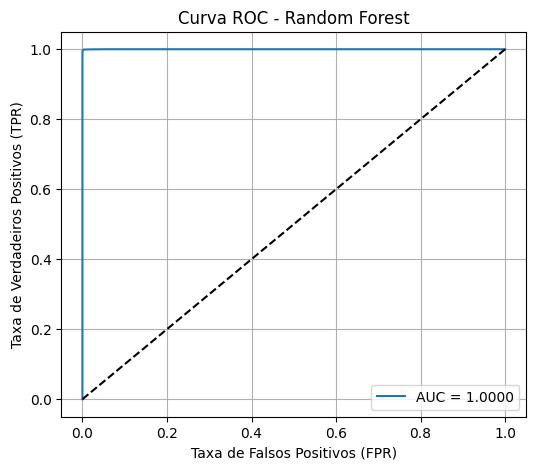

In [39]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - Random Forest')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [43]:
# Gera o relatório com precisão, recall, F1 e suporte por classe
print("Relatório de Classificação - Random Forest:\n")
print(classification_report(y_test, y_pred_rf, target_names=["Não Default", "Default"]))

Relatório de Classificação - Random Forest:

              precision    recall  f1-score   support

 Não Default       1.00      1.00      1.00     58186
     Default       1.00      0.99      0.99     11868

    accuracy                           1.00     70054
   macro avg       1.00      1.00      1.00     70054
weighted avg       1.00      1.00      1.00     70054



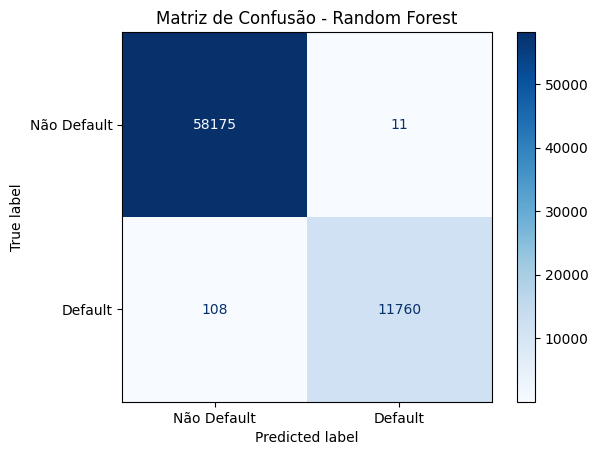

In [44]:
#  Matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Default', 'Default'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Random Forest')
plt.show()


In [45]:
# Matriz de confusão
TN = 58175
FP = 11
FN = 108
TP = 11760

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)

print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")

Taxa de inadimplência na base = 16.939999999999998%
Taxa de aprovação pelo modelo = 16.8%
